# Experiments

In [1]:
import numpy as np
from numba import njit, jit
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import time 

import warnings
warnings.filterwarnings("ignore")

rng = np.random.default_rng()

In [41]:
from pathlib import Path

figure_folder = Path().resolve().parent / 'report_and_presentation' / 'figures'

In [2]:
# utility functions
normalize = lambda x, dim=-1: x /np.sum(x, axis=dim)

## 1D Case : Gaussians 


In [3]:
means = [1., 5., 10.]
stds = [.5, .2, .8] # rng.random(3) + .05
t = np.linspace(-5, 15, 100)

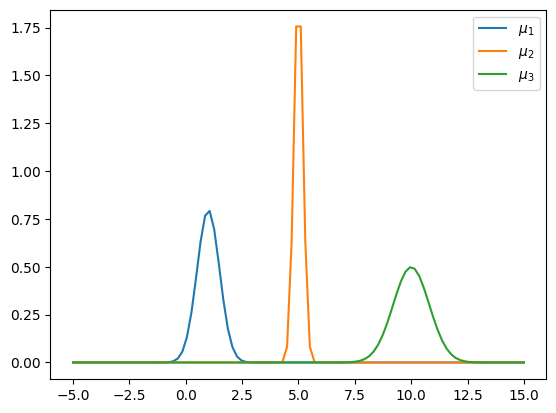

In [4]:
fig = plt.figure()

plt.plot(t, norm.pdf(t, loc=means[0], scale=stds[0]), label='$\mu_1$')
plt.plot(t, norm.pdf(t, loc=means[1], scale=stds[1]), label='$\mu_2$')
plt.plot(t, norm.pdf(t, loc=means[2], scale=stds[2]), label='$\mu_3$')

plt.legend()
plt.show()

### Method on a fixed grid 

In [5]:
# fixed grid 
M = 100
x = np.linspace(-5, 15, M)

#### **Method 1 :** Compute the barycenter on a refined grid using the cumulative function

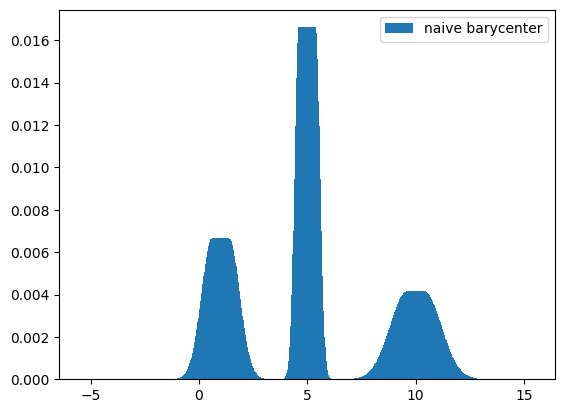

In [97]:
time_naive_0 = time.time()

coeffs = np.zeros(M)
for j in range(3):
    coeffs += norm.pdf(x, loc=means[j], scale=stds[j])
coeffs /= np.sum(coeffs)

time_naive_1 = time.time()

# plot barycenter 
plt.bar(x, coeffs, label='naive barycenter')
# plt.plot(t, norm.pdf(t, loc=means[0], scale=stds[0]), label='$\mu_1$')
# plt.plot(t, norm.pdf(t, loc=means[1], scale=stds[1]), label='$\mu_2$')
# plt.plot(t, norm.pdf(t, loc=means[2], scale=stds[2]), label='$\mu_3$')

plt.legend()

plt.show()

### **Method 2:** Using regularized bregman method

Here, the input measures have to be discretized on the same grid as the target barycenter.

In [6]:
A = np.zeros((M, 3))
vmin = .02
for j in range(3):
    a = norm.pdf(x, loc=means[j], scale=stds[j])
    A[:, j] = normalize( a + a.max()*vmin)

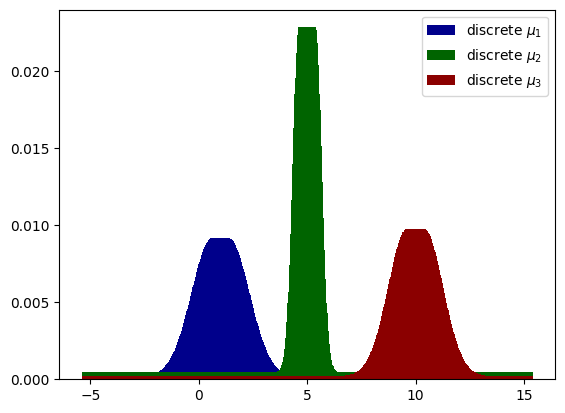

In [39]:
fig = plt.figure()

plt.bar(x, A[:, 0], label='discrete $\mu_1$', color = 'darkblue')
plt.bar(x, A[:, 1], label='discrete $\mu_2$', color = 'darkgreen')
plt.bar(x, A[:, 2], label='discrete $\mu_3$', color = 'darkred')
plt.legend()

plt.show()

In [41]:
# Bregman algo
# uniform weights
weights = np.ones(3) / 3

# Kernel 
epsilon = .05
[Y, X] = np.meshgrid(x, x)
K = np.exp(- (X - Y)**2/ epsilon )

# initialization 
v = np.ones((M, 3))
u = np.copy(v)

niter = 500
for i in tqdm(range(niter)):
    
    # update u
    for k in range(3): 
        u[:, k] = A[:, k] / np.dot(K, v[:, k])
    
    # compute barycenter
    b = np.zeros(M)
    for k in range(3):
        b += weights[k] * np.log( np.maximum(v[:, k] * np.dot(K, u[:, k]),
                                             1e-19*np.ones(M)))
    b = np.exp(b)

    # update v
    for k in range(3):
        v[:, k] = b / np.dot(K, u[:, k])
    

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 204.20it/s]


In [44]:
b = normalize(b)

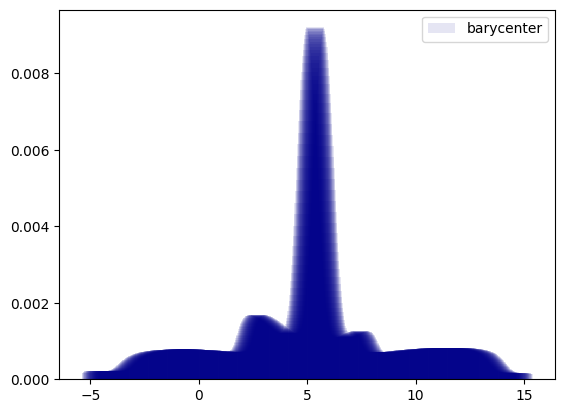

In [46]:
plt.bar(x, b, label='barycenter', color = 'darkblue')

plt.legend()
plt.show()

### **Method 3:** Stochastic wasserstein barycenter without refined grid

$\phi = {\phi_j^i}$

$C = d(x, y)^2 = ||x -y ||_2^2$ is the cost 

In [6]:
@jit
def sample_from_input_distribution(ind_j : int, n_samples : int = 10000):
    return norm.rvs(loc=means[ind_j], scale=stds[ind_j], size=(n_samples, 1))

In [7]:
x = x[:, np.newaxis] # (M, D)
x.shape

(100, 1)

In [ ]:
# [Y, X] = np.meshgrid(x, x)
# C = (X - Y)**2

In [ ]:
# 2D : plot Voronoi diagram 
# t = None
# [Y, X] = np.meshgrid(t, t)
# C = (X - Y)**2

In [11]:
phis = np.zeros((3, M))
Y = sample_from_input_distribution(0, 10)
((Y[0][np.newaxis, :]  - x)**2).sum(-1) - phis[0]

array([3.01361664e+01, 2.79589415e+01, 2.58633409e+01, 2.38493646e+01,
       2.19170127e+01, 2.00662851e+01, 1.82971818e+01, 1.66097028e+01,
       1.50038482e+01, 1.34796179e+01, 1.20370119e+01, 1.06760303e+01,
       9.39667292e+00, 8.19893991e+00, 7.08283122e+00, 6.04834685e+00,
       5.09548681e+00, 4.22425110e+00, 3.43463970e+00, 2.72665263e+00,
       2.10028989e+00, 1.55555147e+00, 1.09243737e+00, 7.10947599e-01,
       4.11082150e-01, 1.92841026e-01, 5.62242253e-02, 1.23174876e-03,
       2.78635963e-02, 1.36119768e-01, 3.26000263e-01, 5.97505083e-01,
       9.50634227e-01, 1.38538769e+00, 1.90176549e+00, 2.49976760e+00,
       3.17939404e+00, 3.94064481e+00, 4.78351989e+00, 5.70801931e+00,
       6.71414304e+00, 7.80189110e+00, 8.97126349e+00, 1.02222602e+01,
       1.15548812e+01, 1.29691266e+01, 1.44649963e+01, 1.60424903e+01,
       1.77016086e+01, 1.94423512e+01, 2.12647182e+01, 2.31687095e+01,
       2.51543252e+01, 2.72215651e+01, 2.93704294e+01, 3.16009180e+01,
      

In [35]:
# 1D 
@njit
def is_in_power_cell(y, ind_i: int, ind_j : int,
                     phis : np.ndarray,
                     barycenter_point : np.ndarray):
    """
    y : (D)
    """
    assert -1 < ind_i < barycenter_point.shape[0]
    assert -1 < ind_j < phis.shape[0]

    c_values = ((y[np.newaxis, :]  - barycenter_point)**2).sum(-1) - phis[ind_j] # (M) 
    in_voronoi = c_values[ind_i] == c_values.min()
    return in_voronoi

@njit
def compute_value_a(ind_i: int, ind_j : int,
                    phis : np.ndarray,
                    Y : np.ndarray, 
                    barycenter_point : np.ndarray):
    """ using Monte Carlo method"""
    assert ind_i < phis.shape[1]
    assert ind_j < phis.shape[0]

    K = Y.shape[0]
    monte_carlo_sum = 0
    for k in range(K):
        monte_carlo_sum += 1.*is_in_power_cell(Y[k], ind_i, ind_j, phis, barycenter_point)
    return monte_carlo_sum / K

@njit
def compute_value_b(ind_i : int, ind_j : int,
                    phis, Y, barycenter_point : np.ndarray):
    """ using Monte Carlo method"""
    assert ind_i < phis.shape[1]
    assert ind_j < phis.shape[0]

    K = Y.shape[0]
    monte_carlo_sum = np.zeros(Y.shape[1])
    for k in range(K):
        monte_carlo_sum += Y[k]*is_in_power_cell(y, ind_i, ind_j, phis, barycenter_point)
    return monte_carlo_sum / K  

@njit
def compute_gradient_phi_ij(ind_i: int, ind_j:int, phis, barycenter_point,
                        Y : np.ndarray):

    
    a_ij = compute_value_a(ind_i, ind_j, phis, Y, barycenter_point) # float
    # print(f'i {ind_i} j {ind_j} a_ij {a_ij}')
    N, M = phis.shape
    grad_f = (1/M - a_ij)/N

    return grad_f, a_ij

@njit
def compute_gradient_phi_j(ind_j : int, phis, barycenter_point,
                           Y : np.ndarray):
    """ 
    Returns :
    grad_phi_j : array (M)
    a_j : array (M)
    """
    M = phis.shape[1]
    grad_phi_j = np.zeros(M)
    a_j = np.zeros(M)
    for i in range(M):
        grad_phi_j[i], a_j[i] = compute_gradient_phi_ij(i, ind_j, phis,
                                                barycenter_point,
                                                Y)
    return grad_phi_j, a_j


In [105]:
# g, a = compute_gradient_phi_j(0, np.zeros((3, M)), x, n_samples=50)
# sam = sample_from_input_distribution(0, 10)
# b = compute_value_b(0, 0, np.zeros((3, M)), sam, x)

In [29]:
n_samples = 16000
nIter = 1
J = 3
D = 1
ascent_eps = 1e-4 # 1e-6
ascent_beta = .99
ascent_alpha = 1e-3

max_while_loop = 1000

In [36]:
phis = np.zeros((J, M))
ascent_criteria_list = []
samples_per_input = [sample_from_input_distribution(j, n_samples=n_samples) for j in range(J)]
for j in range(J):
    z_0 = np.zeros(M)
    # w_0 = phis[j]
    grad_phi_j, _ = compute_gradient_phi_j(j, phis, x,
                                            samples_per_input[j])
    ascent_criteria = [np.linalg.norm(grad_phi_j, ord=1)]

    while ascent_criteria[-1] > ascent_eps:
        z_0 = ascent_beta*z_0 + grad_phi_j
        phis[j] = phis[j] + ascent_alpha*z_0
        # w_0 = w_0 + ascent_alpha*z_0
        # phis[j] = w_0
        grad_phi_j, a_j = compute_gradient_phi_j(j, phis, x,
                                                samples_per_input[j])
        ascent_criteria += [np.linalg.norm(grad_phi_j, ord=1)]
        if len(ascent_criteria) > max_while_loop:
            print('Warning : max_while_loop reached')
            break

    ascent_criteria_list += [ascent_criteria]

In [38]:
ascent_criteria_list[0][-1]

0.5322916666666665

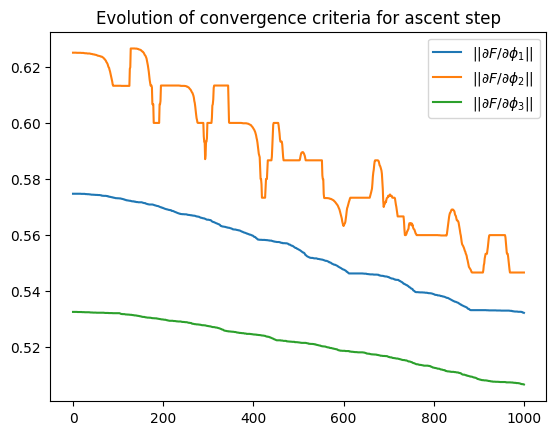

In [49]:
fig = plt.figure()
plt.plot(ascent_criteria_list[0], label='$||\partial F / \partial \phi_1 ||$')
plt.plot(ascent_criteria_list[1], label='$||\partial F / \partial \phi_2 ||$')
plt.plot(ascent_criteria_list[2], label='$||\partial F / \partial \phi_3 ||$')
plt.title(f'Evolution of convergence criteria for ascent step')
plt.legend()
fig.savefig(figure_folder / f'ascent_criteria_nsamples{n_samples}.png')

In [91]:
# Optimizing estimate of barycenter support 
@jit
def ascent_snap_algo(x, nIter: int, n_samples: int,
                     ascent_eps: float = ascent_eps,
                     ascent_beta: float=ascent_beta,
                     ascent_alpha: float=ascent_alpha,
                     max_while_loop: int=max_while_loop):
    # initial potentials
    phis = np.zeros((J, M))
    
    ascent_crit_list = []
    for _ in range(nIter):
        # ascent step 
        weight_a = np.zeros((J, M))
        for j in range(J):
            z_0 = np.zeros(M)
            w_0 = phis[j]
            grad_phi_j, _ = compute_gradient_phi_j(j, phis, x,
                                                    n_samples=n_samples)
            ascent_criteria = [np.linalg.norm(grad_phi_j, ord=1)]

            while ascent_criteria[-1] > ascent_eps:
                z_0 = ascent_beta*z_0 + grad_phi_j
                w_0 = w_0 + ascent_alpha*z_0
                phis[j] = w_0
                grad_phi_j, a_j = compute_gradient_phi_j(j, phis, x,
                                                        n_samples=n_samples)
                ascent_criteria += [np.linalg.norm(grad_phi_j, ord=1)]

                if len(ascent_criteria) > max_while_loop:
                    print('Warning : max_while_loop reached')
                    break

                print('grad', grad_phi_j)
                print('phi_j', phis[j])

            ascent_crit_list.append(ascent_criteria)
            # phis[j] = w_0
            weight_a[j] = a_j
            print(f'criteria for j {j} : {ascent_criteria[-1]}')

        # snap step
        point_b = np.zeros((J, M, D)) # (J, M, D)
        print('--- snap step ---')
        for j in range(J):
            Y = sample_from_input_distribution(j, n_samples=n_samples)
            for i in range(M):
                point_b[j, i] = compute_value_b(i, j, phis, Y, x)
        weight_a = weight_a[:, :, np.newaxis] # (J, M, 1)
        
        for i in range(M):
            x[i] = np.sum(weight_a[:, i] * point_b[:, i], axis=0)
            x[i] /= np.maximum( np.sum(weight_a[:, i]), 1e-19 )

        print('x', x)

    return x, phis, ascent_crit_list, weight_a, point_b

In [92]:
n_samples

10000

In [93]:
time_algo_0 = time.time()

new_x, new_phis, ascent_crit_list, a_j, point_b = ascent_snap_algo(x, nIter, n_samples)

time_algo_1 = time.time()

grad [-0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33]
phi_j [-0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033
 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033
 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033
 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033
 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033
 -0.00033 -0.0

KeyboardInterrupt: 

In [77]:
a_j.shape

(100,)

In [80]:
np.unique(new_phis)

array([-1.21641526])

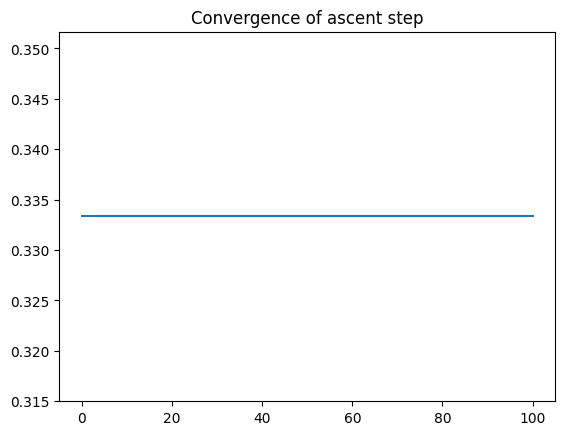

In [72]:
fig = plt.figure()

plt.plot(ascent_crit_list[0])
plt.title('Convergence of ascent step')

plt.show()

In [6]:
# with OT 
import ot 

weights = np.ones(3) / 3

# wasserstein
reg = 1e-3
ot.tic()
bary_wass = ot.bregman.barycenter(A, M, reg, weights)
ot.toc()


# ot.tic()
# bary_wass2 = ot.lp.barycenter(A, M, weights)
# ot.toc()

print('Wass Barycenter with OT : ', bary_wass.shape)

plt.plot(x, bary_wass, label='POT Wass')

plt.legend()
plt.show()

ModuleNotFoundError: No module named 'ot'

## With $J=2$ distributions 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html#scipy.stats.skewnorm
compare the computation using  inverse cumulative function in 1D ! 

## 1D Case : Dirac 

In [ ]:
a1 = np.zeros(M)
a2 = np.zeros(M)

a1[8] = .5
a1[10] = .5
a2[2] = .5
a2[4] = .5

print(a1.sum())

In [ ]:
plt.plot(x, a1, label='$\mu_1$')
plt.plot(x, a2, label='$\mu_2$')
plt.legend()
plt.show()